In [1]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import seaborn as sns
from datetime import timedelta, datetime


dir = Path(r"S:\Fackler_OSS_364376\data\IRB-364376-v1-230215")

In [2]:
fp = dir.joinpath('EHR', 'd_flo_measures.csv.gz')
dict = pd.read_csv(fp, compression="gzip")
# dict.head()
# dict['disp_name'].unique

names = ["State Behavioral Scale",
"-3 Unresponsive", 
"-2 Responsive to noxious stimuli", 
"-1 Responsive to gentle touch or voice",
"0 Awake and Able to calm",
"+1 Restless and difficult to calm",
"+2 Agitated",
"State Behavioral Scale (SBS)"]

dict[dict['disp_name'].isin(names)]

,flo_meas_id,flo_meas_name,site_row_id,record_state_c,allow_comp_yn,disp_name,abbr_p,row_typ_c,chg_trg_type_c,val_type_c,...,flo_row_status_c,row_type,val_type,cross_enc_yn,question_id,question_prompt,question_required_yn,context_c,store_calc_data_yn,show_abbr_c
64810,304080015,G JHM IP PEDS STATE BEHAVIORAL SCALE,NaN,NaN,NaN,State Behavioral Scale,NaN,2.0,NaN,NaN,...,0.0,Flowsheet Group,NaN,N,NaN,NaN,NaN,1.0,NaN,NaN
64811,304080016,R JHM IP AD PEDS SB UNRESPONSIVE,NaN,NaN,NaN,-3 Unresponsive,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64812,304080017,R JHM IP AD PEDS SB RESPONSIVE TO NOXIOUS STIMULI,NaN,NaN,NaN,-2 Responsive to noxious stimuli,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64813,304080018,R JHM IP AD PEDS SB RESPONSIVE TO GENTLE TOUCH...,NaN,NaN,NaN,-1 Responsive to gentle touch or voice,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64814,304080019,R JHM IP AD PEDS SB AWAKE AND ABLE TO CALM,NaN,NaN,NaN,0 Awake and Able to calm,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64815,304080020,R JHM IP AD PEDS SB RESTLESS AND DIFFICULT TO ...,NaN,NaN,NaN,+1 Restless and difficult to calm,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64816,304080021,R JHM IP AD PEDS SB AGITATED,NaN,NaN,NaN,+2 Agitated,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64817,304080022,G JHM IP AD PEDS STATE BEHAVIORAL SCALE (SBS),NaN,NaN,NaN,State Behavioral Scale (SBS),NaN,2.0,NaN,NaN,...,0.0,Flowsheet Group,NaN,N,NaN,NaN,NaN,1.0,NaN,NaN
64818,304080023,R JHM IP AD PEDS STATE BEHAVIORAL SCALE (SBS),NaN,NaN,NaN,State Behavioral Scale (SBS),NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
66624,1570400708,G BH STATE BEHAVIORAL SCALE,NaN,NaN,NaN,State Behavioral Scale (SBS),NaN,2.0,NaN,NaN,...,0.0,Flowsheet Group,NaN,N,NaN,NaN,NaN,1.0,NaN,NaN


In [3]:
# note: flowsheet record flow_meas_id as meas_id
# note: SBS score values are only stored in these fields

fmid = [304080016, 304080017, 304080018, 304080019, 304080020, 304080021]

In [4]:
# connect with feather file
fp = dir.joinpath('EHR', 'ptsd_record.csv.gz')

ptsd_record = pd.read_csv(fp, compression="gzip")
# print(ptsd_record.dtypes)
# ptsd_record.head(2)
patients_ptsd = ptsd_record['pat_enc_csn_sid'].unique()

# load flow table of all patient EHR records
fp = dir.joinpath('EHR', 'flowsheet.csv.gz')

data = pd.read_csv(fp, compression="gzip")
data = data.drop(columns = ['meas_comment', 'meas_template_id'])
# Note: pandas took 50 seconds to load the table. Consider porting to PySpark RDD

In [5]:
# print(data.dtypes)
sbs = data[data['meas_id'].isin(fmid)]
print(sbs.shape)
# 25878 entries

# calculate sbs score from offset
sbs['SBS'] = sbs['meas_id'] - 304080019
sbs = sbs.drop(columns=['meas_value', 'meas_id'])
sbs['recorded_time'] = pd.to_datetime(sbs['recorded_time'], format='%Y-%m-%d %H:%M:%S')
sbs_indiv = sbs.groupby('pat_enc_csn_sid')

# Identify patients with SBS and waveform data
patients_ehr = list(sbs_indiv.groups.keys())

patients = list(set(patients_ehr) & set(patients_ptsd))
print(len(patients))
# 581 patients with both EHR and waveform

(25878, 5)
581


c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Approach 1
Combine SBS and waveforms into a single pandas dataframe

In [6]:
p = patients[0]

files = ptsd_record[ptsd_record['pat_enc_csn_sid'] == p]
files['start_time'] = pd.to_datetime(files['start_time'], format='%Y-%m-%d %H:%M:%S')
files['end_time'] = pd.to_datetime(files['end_time'], format='%Y-%m-%d %H:%M:%S')
files.sort_values('start_time')

devices = files['device']
filename = files['filename'] + '.feather'
startime = files['start_time']

dfs = []

for (d, fn, t0) in zip(devices, filename, startime):
    fp_device = 'vitals-' + d.lower()
    fp_p = str(p)[-3:] # last 3 digit of pat_enc_csn_sid is the subfolder
    fp = dir.joinpath('ptsd-phi', fp_device, fp_p, fn)
    
    # add datetime overlap handling
    df = pd.read_feather(fp, columns=None, use_threads=True, storage_options=None)
    df['delta'] = pd.to_timedelta(df['dts'], unit='s')
    df['recorded_time'] = df['delta'] + t0
    
    # df presents time as delta seconds
    dfs.append(df)
patient_multi = pd.concat(dfs, axis=0)

# add SBS
sbs_p = sbs_indiv.get_group(p).sort_values('recorded_time')
sbs_p = sbs_p.drop(columns=['osler_sid', 'pat_enc_csn_sid'])

patient_merged = pd.merge(patient_multi, sbs_p, how='left')
patient_merged = patient_merged.sort_values(by = ['recorded_time'])

print(patient_merged['SBS'].unique())
print(patient_merged.columns)
patient_merged.head(4)

c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[-1. nan  0.]
Index(['dts', 'AR1-D', 'AR1-M', 'AR1-R', 'AR1-S', 'CVP2', 'HR', 'NBP-D',
       'NBP-M', 'NBP-R', 'NBP-S', 'PVC', 'RR', 'SPO2-%', 'SPO2-R', 'delta',
       'recorded_time', 'SBS'],
      dtype='object')


,dts,AR1-D,AR1-M,AR1-R,AR1-S,CVP2,HR,NBP-D,NBP-M,NBP-R,NBP-S,PVC,RR,SPO2-%,SPO2-R,delta,recorded_time,SBS
1780,0.0,42.0,52.0,106.0,70.0,9.0,106.0,NaN,NaN,NaN,NaN,0.0,22.0,99.0,106.0,0 days 00:00:00,2017-07-08 00:00:00,-1.0
1781,1.0,NaN,NaN,NaN,NaN,NaN,NaN,36.0,49.0,110.0,71.0,NaN,NaN,NaN,NaN,0 days 00:00:01,2017-07-08 00:00:01,NaN
1782,60.0,42.0,52.0,104.0,70.0,9.0,104.0,NaN,NaN,NaN,NaN,0.0,24.0,99.0,106.0,0 days 00:01:00,2017-07-08 00:01:00,NaN
1783,120.0,42.0,52.0,106.0,70.0,9.0,108.0,NaN,NaN,NaN,NaN,0.0,24.0,99.0,106.0,0 days 00:02:00,2017-07-08 00:02:00,NaN


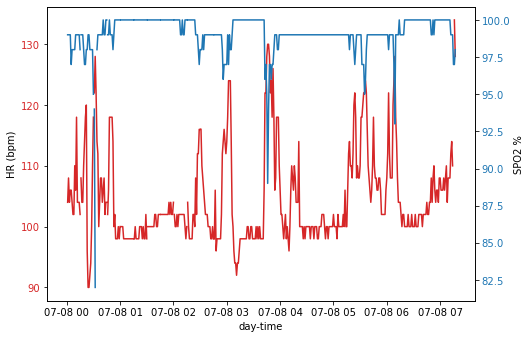

In [13]:
# plot some data from the table
testdata = patient_merged[0:450]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color = 'tab:red'
ax1.plot(testdata['recorded_time'], testdata['HR'], color=color)
ax1.set_xlabel('day-time')
ax1.set_ylabel('HR (bpm)')
ax1.tick_params(axis='y', labelcolor=color)
color = 'tab:blue'
ax2.plot(testdata['recorded_time'], testdata['SPO2-%'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('SPO2 %')
fig.tight_layout()
fig.set_size_inches(8,5)
plt.show()

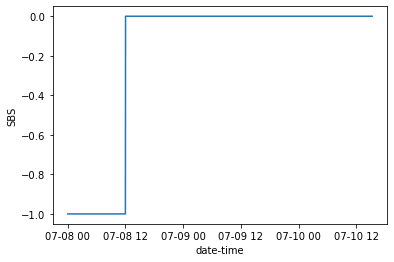

In [17]:
plt.figure()
plt.plot(patient_merged['recorded_time'], patient_merged['SBS'].fillna(method='ffill'))
plt.xlabel('date-time')
plt.ylabel('SBS')
plt.show()

In [131]:
mask = patient_merged['SBS'].isna()
mask

1780    False
1781     True
1782     True
1783     True
1784     True
        ...  
3830     True
3831     True
3832     True
3833     True
3834     True
Name: SBS, Length: 3835, dtype: bool

In [134]:
sbs_p

,recorded_time,SBS
25700849,2017-07-07 16:30:00,0
25756688,2017-07-07 20:00:00,-1
11170452,2017-07-08 00:00:00,-1
25705412,2017-07-08 04:00:00,-1
25700480,2017-07-08 12:00:00,0
25723824,2017-07-08 16:00:00,0


Text(0, 0.5, 'SBS')

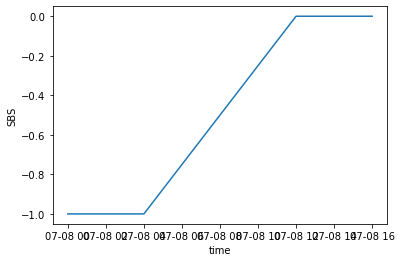

In [133]:
plt.plot(patient_merged['recorded_time'][~mask], patient_merged['SBS'][~mask])
plt.xlabel('time')
plt.ylabel('SBS')

### Approach 2
Segment x seconds of data before each SBS event, and label with SBS score

We will use this ML training

#### Check size of data

In [44]:
data_freq = []

for p in patients[0]:
    files = ptsd_record[ptsd_record['pat_enc_csn_sid'] == p]
    files['start_time'] = pd.to_datetime(files['start_time'], format='%Y-%m-%d %H:%M:%S')
    files['end_time'] = pd.to_datetime(files['end_time'], format='%Y-%m-%d %H:%M:%S')
    files.sort_values('start_time')

    devices = files['device']
    filename = files['filename'] + '.feather'
    startime = files['start_time']

    dfs = []
    size = 0

    for (d, fn, t0) in zip(devices, filename, startime):
        # HL7M', 'TSDB', 'GEVITAL', 'MEDIBUSVITAL
        if (d.endswith('HL7M') or d.endswith('TSDB')):
            fp_device = 'vitals-' + d.lower()
        else:
            fp_device = 'vitals-sb'
            
        fp_p = str(p)[-3:] # last 3 digit of pat_enc_csn_sid is the subfolder
        fp = dir.joinpath('ptsd-phi', fp_device, fp_p, fn)
        
        # TODO: check if file exists

        df = pd.read_feather(fp, columns=None, use_threads=True, storage_options=None)
        df['delta'] = pd.to_timedelta(df['dts'], unit='s')
        df['recorded_time'] = df['delta'] + t0
        size += df.shape[0]

        # df presents time as delta seconds
        dfs.append(df)
    patient_multi = pd.concat(dfs, axis=0)

    # add SBS
    sbs_p = sbs_indiv.get_group(p).sort_values('recorded_time')
    sbs_p = sbs_p.drop(columns=['osler_sid', 'pat_enc_csn_sid'])

    for i in range(len(sbs_p)):
        t1 = sbs_p['recorded_time'].iloc[i]
        t0 = t1 - timedelta(seconds=30*60) # 30 minutes prior

        dat = patient_multi.loc[(patient_multi['recorded_time'] >= t0)
                        & (patient_multi['recorded_time'] <= t1)]
        y = sbs_p.iloc[i]

        data_freq.append(len(dat))

# 11+ mins :(

c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

KeyboardInterrupt: 

#### ML pipeline

In [ ]:
# scale down to 20 patients
for p in patients[0:20]:
    
    files = ptsd_record[ptsd_record['pat_enc_csn_sid'] == p]
    files['start_time'] = pd.to_datetime(files['start_time'], format='%Y-%m-%d %H:%M:%S')
    files['end_time'] = pd.to_datetime(files['end_time'], format='%Y-%m-%d %H:%M:%S')
    files.sort_values('start_time')

    devices = files['device']
    filename = files['filename'] + '.feather'
    startime = files['start_time']

    features = np.

    for (d, fn, t0) in zip(devices, filename, startime):
        # HL7M', 'TSDB', 'GEVITAL', 'MEDIBUSVITAL
        if (d.endswith('HL7M') or d.endswith('TSDB')):
            fp_device = 'vitals-' + d.lower()
        else:
            fp_device = 'vitals-sb'
            
        fp_p = str(p)[-3:] # last 3 digit of pat_enc_csn_sid is the subfolder
        fp = dir.joinpath('ptsd-phi', fp_device, fp_p, fn)
        
        # TODO: check if file exists

        df = pd.read_feather(fp, columns=None, use_threads=True, storage_options=None)
        df['delta'] = pd.to_timedelta(df['dts'], unit='s')
        df['recorded_time'] = df['delta'] + t0
        size += df.shape[0]

        # df presents time as delta seconds
        dfs.append(df)
    patient_multi = pd.concat(dfs, axis=0)

    # add SBS
    sbs_p = sbs_indiv.get_group(p).sort_values('recorded_time')
    sbs_p = sbs_p.drop(columns=['osler_sid', 'pat_enc_csn_sid'])

    for i in range(len(sbs_p)):
        t1 = sbs_p['recorded_time'].iloc[i]
        t0 = t1 - timedelta(seconds=30*60) # 30 minutes prior

        dat = patient_multi.loc[(patient_multi['recorded_time'] >= t0)
                        & (patient_multi['recorded_time'] <= t1)]
        y = sbs_p.iloc[i]

        data_freq.append(len(dat))

# 11+ mins :(

In [13]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline

from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket

X_train, y_train = load_basic_motions(split="train", return_X_y=True)
print(X_train.shape)
print(y_train.shape)

In [32]:
X_train['dim_0'].dtype

# dataframe where col is variable,
# entry is sample
# each cell is a fixed length time series

dtype('O')

In [19]:
y_train

array(['standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'running', 'running', 'running', 'running', 'running', 'running',
       'running', 'running', 'running', 'running', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton'], dtype='<U9')

In [12]:
rocket = Rocket()
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform, y_train)

X_test, y_test = load_basic_motions(split="test", return_X_y=True)
X_test_transform = rocket.transform(X_test)

classifier.score(X_test_transform, y_test)

0.975